<ipython-input-245-d22eeeef4ce8>:72: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(soln.t, np.sin(soln.t)/soln.t, linestyle='dashed') # the analytic solution for n = 1


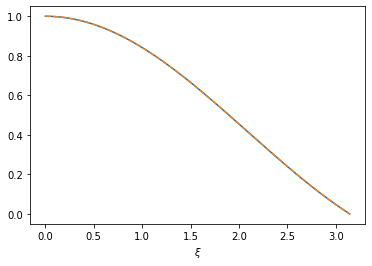

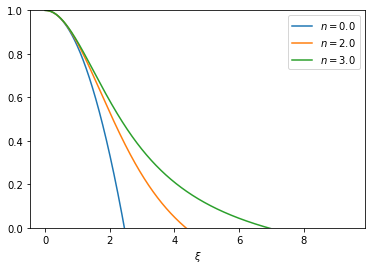

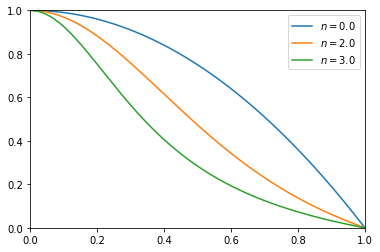

In [245]:
import numpy as np # numpy has various useful functions (e.g., sin(x)), constants (e.g., pi), and data storage routines (e.g., the N-dimentional array: np.array([1,2,3])
from scipy.integrate import solve_ivp # this is the numerical integrator
import pylab as plt # the plotting routines are in plt
# the below will ensure that a call to render the plots with plt.show() will show in the notebook. Otherwise, plt.show() won't result in any image in the notebook.
%matplotlib inline 

# The reformulation of the Lane-Emden equation reads:
# y'' + (2/x)y' + y^n = 0
# where y is the re-scaled density and x is the re-scaled radius
# n is the polytropic index

# This equation can be re-written in a first-order ODE form:
# dY/dx = A x Y
# where A is a matrix 
# A =     0       1
#     -y^(n-1) -(2/x)
# and Y = y
#         y'

# First-order ODEs like the above can be solved numerically in Python.
# In this case, the boundary conditions are at the center of the star (at x = 0) and we want the solution for the rest of the star.
# This is an initial value problem, then: give a value for Y(x=0) and integrate the above equation outward.
# The solution we want is the first row of Y, which is the re-scaled density. The second row is the derivative of the re-scaled density, which we don't care about.

def rhs_poly(x, y, n):
    '''
    Returns the RHS of dY/dx = A x Y (i.e., the derivative w.r.t. x of Y)
    
    Inputs
    x : ndarray
     the independent variable (re-scaled radius)
    y : two-element list/ndarray
     the dependent variable, Y (re-scaled density and its derivative)
    n : int
     the polytropic index
     
    Outputs
    z : two-element list/ndarray
     the derivative of Y, dY/dx    
    '''
    
    # z is the derivative of Y w.r.t. x and is the output of this 
    z = [0,0] # the output is a two-element vector, so give the output dummy values for now that will be filled in later.
    
   
    # there is a singularity at 0 so need to explicitly set the derivative of Y to be 0 near x = 0.
    if x < 1e-7:
        z[0] = 0.0
        z[1] = 0.0
    else:
        z[1] = -y[0]**(n-1)*y[0] - 2/x*y[1] # derivative of y' (i.e., y'')
    
        z[0] = 0*y[0] + 1.0*y[1] # derivative of y !!! complete this line --- what is the derivative of the first element in terms of y[0] and y[1]?
    
    return z

y0 = [1.0, 0.0] # the boundary conditions: the re-scaled density must be 1 at the center of the star by definition. the derivative should be zero at the center.
n = 1.0 # set the polytropic index

# solve_ivp documentation: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp
# take time to read the documentation to understand the following call.
# Note that we want to integrate n = 1.0 from 0 to pi, since we know the analytic solution in theory has the radius of the star at x=pi.

soln = solve_ivp(rhs_poly, [0, np.pi], y0, method='RK45', max_step=1e-3, args=[n]) # RK45 is a Runge-Kutta integration scheme

# soln.t is the independent variable (i.e., the re-scaled radius)
# soln.y is the dependent variable (i.e., the solution to dY/dx = A x Y

plt.plot(soln.t, soln.y[0,:]) # the numerical solution for n = 1 (only caring about the first row: B[c,d] is the cth row and dth column; B[c,:] is every column of the cth row.

# !!! plot the analytic solution, using the numpy function np.sin: https://numpy.org/doc/stable/reference/generated/numpy.sin.html
plt.plot(soln.t, np.sin(soln.t)/soln.t, linestyle='dashed') # the analytic solution for n = 1
plt.xlabel(r'$\xi$') # add a label. the r'$$' format means you can render equations in the plot.
plt.show()
# add labels using plt.xlabel()

# !!! uncomment the below to show the behavior of the Lane-Emden solutions for increasing n. 
ns = [0.0, 2.0, 3.0]
for n in ns:
    soln = solve_ivp(rhs_poly, [0, np.pi*3.0], y0, method='RK45', max_step=1e-3, args=[n])
    plt.plot(soln.t, soln.y[0,:], label=r'$n = {}$'.format(n))
    plt.ylim([0, 1]) # force the y-axis limits to go from 0 to 1.
plt.xlabel(r'$\xi$')
plt.legend() # put the legend on the plot.
plt.show()

# It is not quite fair to compare the solutions as a function of the re-scaled radius, since they have different scale-factors, alpha_n.
# !!! Copy the above for loop and add a line that will normalize the re-scaled radius so that the outside of every solution occurs at x = 1 on the plot.
# Do this first for the n = 1 case.
# Determine the 
from scipy.optimize import root_scalar
from scipy import interpolate

ns = [0.0, 2.0, 3.0]
for n in ns:
    soln = solve_ivp(rhs_poly, [0, np.pi*3.0], y0, method='RK45', max_step=1e-3, args=[n])
    interp = interpolate.UnivariateSpline(soln.t, soln.y[0,:], k=1, s=0) # use UnivariateSpline instead of interp1d because can take the derivative
    theta = lambda x, n: interp(x)
    Rx = root_scalar(theta, args=n, bracket=[0, 6*np.pi]).root
    plt.plot(soln.t/Rx, soln.y[0,:], label=r'$n = {}$'.format(n))
    plt.ylim([0, 1]) # force the y-axis limits to go from 0 to 1.
    plt.xlim([0, 1]) # force the x-axis limits to go from 0 to 1.
plt.legend()
plt.show()

In [276]:
from scipy.integrate import quad
from scipy.optimize import root_scalar
from my_routines.const import G, Msun, Rsun, hbar, c, fgamma, mamu, mubar
from scipy import interpolate

# Will solve for the adiabatic radial amplitude eigenfunction, zeta(r)/r, in the limit
# of high frequency/radial order for the case of a polytrope.

# Because the ODE solver will make multiple calls to P0, rho0, and Gamma0, you will want to 
# fix the polytrope equilibrium structure at the beginning and solve it for n once, now.

# solve for the equilibrium polytrope behavior
y0 = [1.0, 0.0]
n = 3.0 # fix n for the 
# first solve to get the radius
soln = solve_ivp(rhs_poly, [0, 6*np.pi], y0, method='RK45', max_step=1e-3, args=[n]) # RK45 is a Runge-Kutta scheme
# calculate the radius of the star, R = x*Rx
interp = interpolate.UnivariateSpline(soln.t, soln.y[0,:], k=3, s=0) # use UnivariateSpline instead of interp1d because it is fast to evaluate for later integrations
theta = lambda x, n: interp(x)
# find the root of theta to find the radius of the star in re-scaled radii, x = r*alpha
Rx = root_scalar(theta, args=n, bracket=[0, 6*np.pi], xtol=1e-10).root
# use this radius to define theta up to and including Rx.
soln = solve_ivp(rhs_poly, [0, Rx], y0, method='RK45', max_step=1e-3, args=[n]) # RK45 is a Runge-Kutta scheme
interp = interpolate.UnivariateSpline(soln.t, soln.y[0,:], k=3, s=0, ext=3) # use UnivariateSpline instead of interp1d because can take the derivative
interpd = interpolate.UnivariateSpline(soln.t, soln.y[1,:], k=3, s=0, ext=3) # this is the derivative of theta
interpr = interpolate.UnivariateSpline(soln.t, soln.y[1,:]/soln.y[0,:], k=3, s=0, ext=3) # this is d theta /dx /theta
# ext = 3 means to return the boundary value when extrapolating beyond the training points

# define functions based on these interpolators. note that n is fixed in the above line and so even though theta and thetaprime are technically a function of n
# it is a dummy input and does nothing.
theta = lambda x, n: interp(x)
thetaprime = lambda x, n: interpd(x)
thetar = lambda x, n: interpr(x)

# Exercise 1:
# find the central density as a function of the total mass of the star, M, and radius, R.
# Hint: begin by showing what the average density is using the equation of conservation of mass

# this is the average density of a star of known M and R
def rhoavg(M, R):
    '''
    Average density of star with mass M and radius R
    Inputs
    M : float
     mass of the star in g
    R : float
     radius of the star in cm
    '''
    return M/(4.*np.pi/3.*R**3)

def _rhocen(M, R, n):
    '''
    Returns the central density of a star of polytropic index n and mass M
    Inputs
    M : float
     the mass of the star in g
    R : float
     the radius of the star in cm
    n : float
     the polytropic index
    Outputs
    Central density (scalar)
    '''
    def integrand(x, M, R):
        return theta(x, n)**n*x**2
    return Rx**3/quad(integrand, 0, Rx, args=(M, R))[0]/3.*rhoavg(M, R)

# once M, R, and n are set, fix rhocen because it will not change. this makes the integration go much faster because
# the problem does not require integrating at each evaluation in the ODE solver.
rhocenval = _rhocen(Msun, Rsun, n)
rhocen = lambda M, R, n: rhocenval

def alpha(n, M, R):
    '''
    Returns the polytropic constant, alpha
    Inputs
    M : float
     the mass of the star in g
    R : float
     the radius of the star in cm
    n : float
     the polytropic index
    Outputs
    The radius scale factor, such that x = r/alpha
    '''
    return R/Rx
    
def K(n, M, R):
    '''
    Returns the polytropic constant, K_n
    Inputs
    M : float
     the mass of the star in g
    R : float
     the radius of the star in cm
    n : float
     the polytropic index
    Outputs
    Polytropic constant, K_n
    '''
    return alpha(n, M, R)**2*4.*np.pi*G*rhocen(M, R, n)/(n+1)


def rho0(x, n, M, R):
    '''
    The density for polytrope of index n
    Inputs
    x : ndarray or float
     re-scale radial coordinate, xi
    n : float
     polytropic index
    M : float
     stellar mass in g
    R : float
     stellar radius in cm
    Outputs
    ndarray or float
     density at re-scaled radial coordinate, xi
    '''
    return theta(x, n)**n*rhocen(M, R, n)

def P0(x, n, M, R):
    '''
    The pressure for polytrope of index n
    Inputs
    x : ndarray or float
     re-scale radial coordinate, xi
    n : float
     polytropic index
    M : float
     stellar mass in g
    R : float
     stellar radius in cm
    Outputs
    ndarray or float
     pressure at re-scaled radial coordinate, xi
    '''
    return K(n, M, R)*rho0(x, n, M, R)**(1.+1./n)

def Gamma0(x):
    '''
    The assumed Gamma_1 as a function of radius
    Inputs
    x : ndarray or float
    Outputs
     Gamma_1, the adiabatic index. assumed to be constant at every radius.
     schw is the Schwarzchild value and monatomic is for a monatomic ideal gas
    '''
    monatomic = 5./3.
    schw = 4./(-0.4+3) # a = 0.4 from schwarzschild
    return monatomic
    #return schw


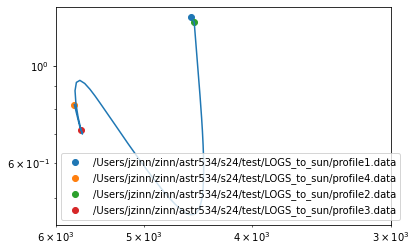

ValueError: no field of name photosphere_r

In [288]:
import mesa_reader # this will enable rading the stellar data
import glob # this will help with getting filenames in the directory storing the MESA output
# this will show each profile on an H-R diagram


# this will show the H-R diagram
files = glob.glob('/Users/jzinn/zinn/astr534/s24/test/LOGS_to_sun/profile*.data')
for f in files:
    mesa_header = mesa_reader.MesaData(f).header_data
    plt.scatter(mesa_header['Teff'], mesa_header['photosphere_L'], label=f)
    plt.legend()
mesa_header = mesa_reader.MesaData('/Users/jzinn/zinn/astr534/s24/test/LOGS_to_sun/history.data').bulk_data
plt.plot(10**mesa_header['log_Teff'], 10**mesa_header['log_L'], label=f)

plt.xscale('log') # H-R diagrams are shown in log-log space
plt.yscale('log') 
plt.xlim([6000, 3000]) # with the x-axis backward
plt.show()

mesa = mesa_reader.MesaData('/Users/jzinn/zinn/astr534/s24/test/LOGS_to_sun/profile4.data').bulk_data
mesa_header = mesa_reader.MesaData('/Users/jzinn/zinn/astr534/s24/test/LOGS_to_sun/profile4.data').header_data

N = 100
x = np.linspace(1e-10, Rx, N)

plt.plot(10.**mesa['logR']/mesa_header['photosphere_r'], 10.**mesa['logP']/10.**mesa['logP'][-1], color='red', label='MESA')
x_plot = np.linspace(0, Rx, 1000)

plt.plot(x/Rx, P0(x, 3, Msun, Rsun)/P0(0, 3, Msun, Rsun), color='green', label='polytrope')

plt.plot(10.**mesa['logR']/mesa_header['photosphere_r'], 10.**mesa['logRho']/10.**mesa['logRho'][-1], color='red', label='MESA', linestyle='dashed')
x_plot = np.linspace(0, Rx, 1000)

plt.plot(x/Rx, rho0(x, 3, Msun, Rsun)/rho0(0, 3, Msun, Rsun), color='green', label='polytrope', linestyle='dashed')
plt.xlabel('r/R')
plt.legend()
plt.xscale('linear')
plt.yscale('log')
plt.xlim([0, 1e0])
plt.ylim([1e-9, 1e0])
# plot up Gamma and see if that is what is going on.
plt.show()

# Exercise 2
# Make another plot showing the temperature gradient compared to the adiabatic temperature gradient. 
# Describe in words what is happening to the thermal gradient as the star evolves (from profile1 to profile4).
# Would there be a better polytrope to describe the early Sun?
# For the region that is convective, show that the actual gradient is very close to the adiabatic gradient (up to the outer layers of 0.95R)

plt.plot(10.**mesa['logR']/mesa_header['photosphere_r'], mesa['gradT'] - mesa['grada'])
plt.ylabel(r'$\nabla_{\mathrm{act}} - \nabla_{\mathrm{ad}}$')
plt.xlabel('r/R')
plt.xlim([0.7, 0.95])
plt.ylim([-1e-3, 1e-3])
plt.show()



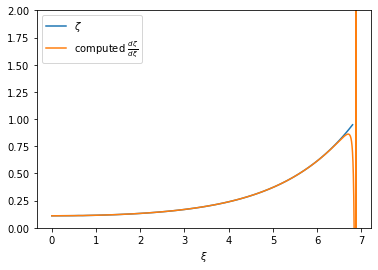

In [273]:
# this cell is trying to use the radial pulsation equation without defining all the Bs and As and things
def iududx(x, n, M, R):
    #return thetaprime(x, n)/theta(x, n)
    return thetar(x, n)

def u(x, n, M, R):
    return theta(x,n)

def omega(nradial, n, M, R):
    return np.sqrt(0.10391)

def rhs(x, y, n, M, R):
    '''
    Returns the RHS of dY/dx = A*Y (i.e., the derivative w.r.t. x of Y
    '''
    # z is the derivative of Y w.r.t. x:
    z = [0,0]
    
    z[0] = 0*y[0] + 1.0*y[1]
    
    # there is a singularity at 0 so need to explicitly set the derivative of Y to be 0.
    if x < 1e-10:
        return np.inf
    else:
        z[1] = y[1]*(-4./x-4.*iududx(x,n,M,R)) + y[0]*(-omega(0,n,M,R)**2/u(x,n,M,R)-0.4*4.0/x*iududx(x,n,M,R))
    return z

# Write a code that will solve the pulsation equation for a polytrope.

import pandas as pd
x = np.linspace(1e-10, Rx) # this is the re-scaled radius array, going from 0 to the outer radius.
# This file has the radial displacement computed for a n = 3 polytrope with adiabatic index of 4./(-0.4+3) (close but not quite 5/3) for a frequency
# corresponding to omega^2 = 0.10391.
# The first column ('x') is the re-scaled radius and the second column ('r') is the radial displacement (delta r)/r.
dat = pd.read_csv('/Users/jzinn/zinn/astr534/s24/data/schwarzschild1941.dat', sep=',')
# this will interpolate the radial displacement. the way to evaluate the radial displacement is by doing interpdat(x), where x is either a float or ndarray.
#interpdat = interpolate.UnivariateSpline(dat['x'], dat['r'], k=1, s=0, ext=3)
# the derivative of the displacement can also be calculated by calling the derivative method, e.g.: interpdat.derivative()(x).
#plt.plot(x, interpdat.derivative()(x), label=r'$\frac{d \zeta}{d \xi}$')
plt.plot(dat['x'], dat['r'], label=r"$\zeta$")
plt.xlabel(r'$\xi$')

# Use the values of the Schwarzschild solution at x = 0 to as initial conditions to solve for the radial displacement by integrating the radial pulsation equation from the inside of the star to the outside
y0 = [interpdat(0), interpdat.derivative()(0)]

soln2 = solve_ivp(rhs, [x[0], x[-1]], y0, method='RK45', max_step=1e-3, args=(n, Msun, Rsun)) # RK45 is a Runge-Kutta scheme max_step=1e-3

# Compare the resulting radial displacement function to the Schwarzschild solution by plotting the solutions on top of each other.
plt.ylim([0,2])
plt.plot(soln2.t, soln2.y[0,:], label=r'$\mathrm{computed\ }\frac{d \zeta}{d \xi}$')
plt.legend()
plt.show()



In [ ]:
# Now let's try adding a realistic pressure profile and compare it to the theoretical n = 3 one.

MESA is a stellar structure code that solves the equations of stellar structure, including time-dependent evolution
of the structure due to the energy equation.

MESA is installed on the machines and we will be using it to run a solar model in class.

Begin by creating a directory called 1msun under astr534. This will be where the model is evolved.

>>> cd astr534

>>> mkdir 1msun

>>> cd 1msun

And copy over the MESA run files to this directory

>>> cp ~/mesa_files/1msun/* ./

Compile the code

>>> ./mk

And run

>>> ./rn

This will evolve the star to the radius of the Sun.

you will want to set history_interval = 1
since this dictates how often you will save information as the star evolves.

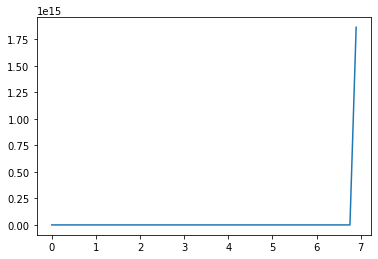

In [274]:
plt.plot(x, iududx(x,n,M,R))
#plt.plot(x, 1./u(x,n,M,R))
plt.show()

6.896848646066022
0.0016025426640887774
0.007308377730328183


/Users/jzinn/envs/anaconda/envs/py38/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.2' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


0     0.11046
1     0.11122
2     0.11166
3     0.11283
4     0.11219
       ...   
79    0.84921
80    0.87278
81    0.89706
82    0.92207
83    0.94784
Name: r, Length: 84, dtype: float64
735.5978943499883
from schw41, omega^2 is 0.10391 and in his definition the corresponds to:
11.766131170680664
0.10391
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          2.55e+01       3.24e-06          100           (195)     
Number of nodes is exceeded after iteration 1. 
Maximum relative residual: 2.55e+01 
Maximum boundary residual: 3.24e-06
[ 0.0019  0.0019  0.0019  0.0019  0.0019  0.0019  0.0044  0.0044  0.0117
 -0.0064 -0.0064  0.0138  0.0085  0.0096  0.0096  0.0108  0.012   0.012
  0.0132  0.0146  0.0146  0.0159  0.0174  0.0189  0.0189  0.0205  0.0222
  0.0222  0.024   0.0259  0.0259  0.0278  0.03    0.03    0.0322  0.0345
  0.037   0.037   0.0397  0.0424  0.0424  0.0454  0.0485  0.0485  0.0519
  0.0554  0.0591  0.0591  0.0631  0.0673  0.0673  0.07

KeyError: 'r'

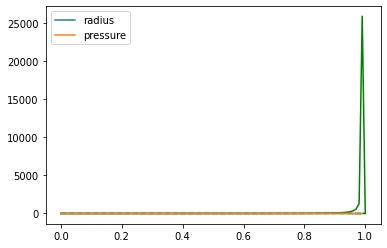

In [82]:
# to compute the pressure and density variations

from scipy.integrate import solve_bvp

# we are going to try solving this as a boundary value problem in scipy.
# to do so we need to calculate dlnP/dr and M(r)
# this is only defined for the set n for the problem
# P0 is only valid for [0, Rx] so interpolator needs to be on this grid.
Nx = 100
x = np.linspace(0, Rx*0.99999, Nx)
print(Rx)
lnPinterp = interpolate.UnivariateSpline(x, np.log(P0(x, n, Msun, Rsun)), k=1, s=0)
Pinterp = interpolate.UnivariateSpline(x, P0(x, n, Msun, Rsun), k=1, s=0)
nradial = 4
M = Msun
R = Rsun

def dlnPdr(x, n, R, M):
    #if x[0] < 1e-7 or x[-1] > Rx:
    #    return 0
    return 1./alpha(n, M, R)*lnPinterp.derivative()(x)

def dPdr(x, n, R, M):
    #if x[0] < 1e-7 or x[-1] > Rx:
    #    return 0
    return 1./alpha(n, M, R)*Pinterp.derivative()(x)

def omega(nradial, n, M, R):
    return np.sqrt(0.10391*np.pi*G*Gamma0(0)*rhocen(n, M, R))
print(omega(1, 3, M, R))
def omega(nradial, n, M, R):
    return 2.0*(nradial - 0.5)*np.pi*Dnu(n, M, R)
print(omega(2, 3, M, R))


def fun(x, y, p=[1], M=Msun, R=Rsun):
    #print(y)
    y0 = 0.0*x#-3*y[0]/x - 1./Gamma0(x)*y[1]/x
    #print(dPdr(x, n, M, R))
    #print(dlnPdr(x, n, M, R))
    #print(dlnPdr(x, n, M, R))
    #print(x)
    y1 = alpha(n, M, R)*dlnPdr(x, n, M, R)*(-4.*y[0] + p[0]*omega(nradial, n, M, R)**2*alpha(n, M, R)*x*rho0(x, n, M, R)/dPdr(x, n, M, R)*y[0] - y[1])
    return np.vstack((y0, y1))

def fun_vec(x, y, p=[1], M=Msun, R=Rsun):
    return alpha(n, M, R)*dlnPdr(x, n, M, R)*(-4.*y[0,:] + p[0]*omega(nradial, n, M, R)**2*alpha(n, M, R)*x*rho0(x, n, M, R)/dPdr(x, n, M, R)*y[0, :] - y[1,:])

def bc2a(r, p, k=[1]):
    return 4*r+k[0]*omega(nradial, n, M, R)**2*(Rx*alpha(n, M, R))**3/G/M*r + p

def bc2b(r, p, k=[1]):
    return p - 1.5

def bc(ya, yb, p=[1]):
    bc1 = ya[0]*3.+1./Gamma0(x)*ya[1]
    bc2 = bc2b(yb[0], yb[1], p)
    bc3 = bc2a(yb[0], yb[1], p)

    return np.array([bc1, bc3])
def bcp(ya, yb, p=[1]):
    bc1 = ya[0]*3.+1./Gamma0(x)*ya[1]
    bc2 = bc2b(yb[0], yb[1], p)
    bc3 = bc2a(yb[0], yb[1], p)
    return np.array([bc1, bc2, bc3])

def fun_jac(x, y, p=[1]):
    # the shape is i, j, n
    # dfi/dfj
    jac = np.ones(shape=(2, 2, y.shape[1]))
    jac[0,0,:] = -1/x*3#0.0 # df0/dy0
    jac[0,1,:] = -1/x/Gamma0(x)#0.0 # df0/dy1
    #print(dlnPdr(x, n, M, R)*(-4. + p[0]*omega(nradial, n, M, R)**2*alpha(n, M, R)**2*x*rho0(x, n, M, R)/dPdr(x, n, M, R)))
    jac[1,0,:] = alpha(n, M, R)*dlnPdr(x, n, M, R)*(-4. + p[0]*omega(nradial, n, M, R)**2*alpha(n, M, R)*x*rho0(x, n, M, R)/dPdr(x, n, M, R)) # df1/dy0
    jac[1,1,:] = alpha(n, M, R)*dlnPdr(x, n, M, R)*(-1.0)# df1/dy1       
    jac1 = np.ones(shape=(2, 1, y.shape[1]))
    jac1[1, 0, :] = alpha(n, M, R)*dlnPdr(x, n, M, R)*(omega(nradial, n, M, R)**2*alpha(n, M, R)*x*rho0(x, n, M, R)/dPdr(x, n, M, R)*y[0,:])# df1/dp
    jac1[0, 0, :] = 0.0 # df0/dp
    # df/dp
    return (jac, jac1)
def fun_jac_np(x, y, p=[1]):
    jac, jac1 = fun_jac(x, y, p=[1])
    return jac
def bc_jac(ya, yb, p):
    jaca = np.ones(shape=(3, 2))
    jaca[0,0] = 3.# dbc0/dya0
    jaca[0,1] = 1./Gamma0(x) # dbc0/dya1
    jaca[1,0] = 0.0 # dbc1/dya0
    jaca[1,1] = 0.0 # dbc1/dya1
    jaca[2,0] = 0.0 # dbc2/dya0
    jaca[2,1] = 0.0 # dbc2/dya1
    jacb = np.ones(shape=(3, 2))
    jacb[0,0] = 0.0 # dbc0/dyb0
    jacb[0,1] = 0.0 # dbc0/dyb1
    jacb[1,0] = 1.0 # dbc1/dyb0
    jacb[1,1] = 0.0 # dbc1/dyb1
    jacb[2,0] = 4.0 + p[0]*omega(nradial, n, M, R)**2*(Rx*alpha(n, M, R))**3/G/M # dbc2/dyb0
    jacb[2,1] = 1.0 #dbc2/dyb1
    jacc = np.ones(shape=(3, 1))
    jacc[0, 0] = 0.0 # dbc0/dp0
    jacc[1, 0] = 0.0 # dbc1/dp0
    jacc[2, 0] = omega(nradial, n, M, R)**2*(Rx*alpha(n, M, R))**3/G/M*yb[0] # dbc2/dp
    return (jaca, jacb, jacc)

# make a mesh. this is similar to how GYRE computes a mesh
N = 100
x = np.logspace(-10, np.log10(Rx), N)
x = np.linspace(1e-10, Rx, N)
y_a = np.zeros((2, x.size))
y_a[0,-1] = 1.0
y_a[1,-1] = 1.0
y_a[0,0] = 0.1
y_a[1,0] = 0.3
import pandas as pd
dat = pd.read_csv('/Users/jzinn/zinn/astr534/s24/data/schwarzschild1941.dat', sep=',')
print(dat['r'])
interpdat = interpolate.interp1d(dat['x'], dat['r'], fill_value=(dat['r'].iloc[0], dat['r'].iloc[-1]), bounds_error=False)
interpdat = interpolate.UnivariateSpline(dat['x'], dat['r'], k=1, s=0)
y_a[0,:] = interpdat(x)

dat = pd.read_csv('/Users/jzinn/zinn/astr534/s24/data/schwarzschild1941_rhoap4.dat', sep=',')
interpdatrho = interpolate.interp1d(dat['x'], dat['rho'], fill_value=(dat['rho'].iloc[0], dat['rho'].iloc[-1]), bounds_error=False)
interpdatrho = interpolate.UnivariateSpline(dat['x'], dat['rho'], k=1, s=0)
y_a[1,:] = Gamma0(x)*interpdatrho(x) # convert from density to pressure variations


#y_a[1,:] = interpdat(x)
#y_a[0,:] = np.exp(x/(Rx))/np.e*np.sin(x*2.*np.pi/(nradial*Rx))+0.3
##y_a[1,:] = y_a[0,:]
#y_a[0,0] = 0.3
#y_a[1,0] = 0.3
#print(y_a[0,:])
print(omega(nradial, n, M, R)**2*(Rx*alpha(n, M, R))**3/G/M)
print('from schw41, omega^2 is 0.10391 and in his definition the corresponds to:')
print(omega(nradial, n, M, R)**2/(np.pi*G*Gamma0(0)*rhocen(n, M, R)))
print((0.10391))

x_plot = np.linspace(0, Rx, 1000)
#plt.plot(x/Rx, y_a[0,:])
#plt.plot(x/Rx, y_a[1,:])

# !!! I think this may work if p is set to be what it should be 
# let's see if schwarzschild's solutions actually solve the equations for n = 3
plt.plot(x/Rx, Gamma0(x)*interpdatrho.derivative()(x), color='green', linestyle='dashed')
plt.plot(x/Rx, fun_vec(x, np.vstack((interpdat(x), Gamma0(x)*interpdatrho(x)))), color='green')
#plt.ylim([-2, 20])

#plt.plot(x/Rx, interpdat.derivative()(x), color='red', linestyle='dashed')
#plt.plot(x/Rx, -(interpdat(x)*3. + interpdatrho(x))/x, color='red')
#plt.plot(x/Rx, interpdat(x)*3. + interpdatrho(x))
#plt.plot(x/Rx, interpdat(x))
#print((interpdat(x)*3. + interpdatrho(x))/x)

#plt.ylim([0, 10])
#res_a = solve_bvp(fun, bcp, x, y_a, S=[[-3.0, -1./Gamma0(0)], [0, 0]], p=[1], verbose=2, max_nodes=50000, fun_jac=fun_jac, bc_jac=bc_jac)
res_a = solve_bvp(fun, bc, x, y_a, S=[[-3.0, -1./Gamma0(0)], [0, 0]], verbose=2, max_nodes=100, fun_jac=fun_jac_np)
x_plot = np.linspace(0, Rx*0.99, 1000)
#print(bc(res_a.sol(0), res_a.sol(Rx), [1]))
#print(res_a.sol(x_plot)[1])

r_plot_a = res_a.sol(x_plot)[0]
p_plot_a = res_a.sol(x_plot)[1]
plt.plot(x_plot/Rx, r_plot_a, label='radius')
plt.plot(x_plot/Rx, p_plot_a, label='pressure')

#plt.plot(x_plot/Rx, interp(x_plot))
#plt.plot(x_plot/Rx, Pinterp(x_plot))
#print(rho0(x_plot, n, M, R))
#plt.plot(x_plot/Rx, rho0(x_plot, n, M, R))
#plt.plot(x_plot/Rx, dPdr(x_plot, n, M, R))
#plt.plot(x_plot/Rx, theta(x_plot, n)**n)
#plt.plot(soln.t/Rx, soln.y[0,:])
#print(bc2a(r_plot_a[-1], p_plot_a[-1]))
#print(res_a.p)
#print(r_plot_a[0]*3+1./Gamma0(0)*p_plot_a[0])
plt.legend()
# this is the case for n = 3 and a = 0.4 (a = 3 - (4/Gamma0))
#y_a[0] = 

#print(y_a[0]
print(interpdat.derivative()(x))
print(interpdat(x))
print(dat['r'])

SyntaxError: invalid syntax (<ipython-input-11-580adc17fda2>, line 3)

NameError: name 'x' is not defined

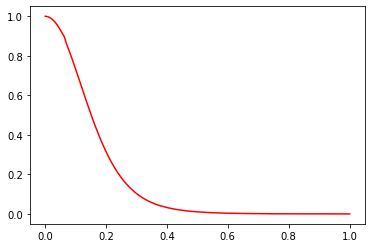

In [ ]:
Now we can use this stellar structure to compute the eigenfunctions of pulsations that are supported.


every person in the group do a luminosity of cephieds and get their period
use period reltaionship to get luminosities and therefore luminosity distances for all the things
see if can get hubble constant using that
try different metallicities
